# Link Colab with google drive

In [1]:
import os
from src.run_experiment import Experiment, same_seeds
from models.autoencoder import AutoEncoder
from models.clustering import PhaseClassifier
from load_dataset.exhaust import *
from py_widgets.widgets import *

# Make sure that you can always have updated modules/functions from other python files.
%load_ext autoreload
%autoreload 2

# Dataset preprocessing

## View the dataset
Load the .bcf file and create an object of `SEMDataset` (which uses hyperspy as backend.)

Something you can do with the `sem` object:
1. `sem.bse`: access the back-scattered electron image.

2. `sem.edx`: access the edx dataset.

3. `plot_sum_spectrum(sem.edx)`: view the sum spectrum (or use hyperspy built-in function `sem.edx.sum().plot(xray_lines=True)`).

4. `sem.feature_list`: view the default chosen elemental peaks in the edx dataset.

5. `sem.set_feature_list`: set new elemental peaks. 


In [6]:
# Load .bcf file
root = os.getcwd() 
file_path = os.path.join(root, '..', 'bcf_files/XLI_exhaust_011.bcf')
# '\Tenham PM4J glassypool.bcf'                     
# '\XLI_exhaust_011.bcf'

sem = SEMDataset(file_path)

In [35]:
hs.load(file_path)[0].data.shape

(672, 739)

├── Acquisition_instrument
│   └── SEM
│       ├── Detector
│       │   └── EDS
│       │       ├── azimuth_angle = 45.0
│       │       ├── detector_type = XFlash 6|30
│       │       ├── elevation_angle = 35.0
│       │       ├── energy_resolution_MnKa = 130.0
│       │       ├── live_time = 653.257
│       │       └── real_time = 703.196928
│       ├── Stage
│       │   ├── rotation = 0.025
│       │   ├── tilt_alpha = 0
│       │   ├── x = 26284.0
│       │   ├── y = -1347.0
│       │   └── z = 13000.6829156682
│       ├── beam_energy = 15.0
│       └── magnification = 10191.26669
├── General
│   ├── date = 2021-07-24
│   ├── original_filename = XLI_exhaust_011.bcf
│   ├── time = 10:31:40
│   └── title = EDX
├── Sample
│   ├── elements = ['Al', 'C', 'Ca', 'Cl', 'Cr', 'Fe', 'Mn', 'O', 'Si']
│   ├── name = Undefinded
│   └── xray_lines = ['Al_Ka', 'C_Ka', 'Ca_Ka', 'Cl_Ka', 'Cr_Ka', 'Fe_Ka', 'Mn_Ka', 'O_Ka', 'Si_Ka']
└── Signal
    ├── binned = True
    ├── quantity = X-rays (Counts)


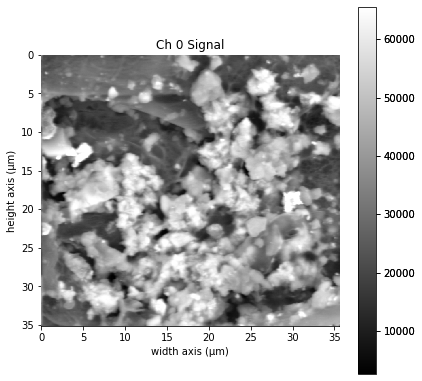

In [7]:
print(sem.edx.metadata)
print(sem.bse.metadata)
sem.bse.plot()

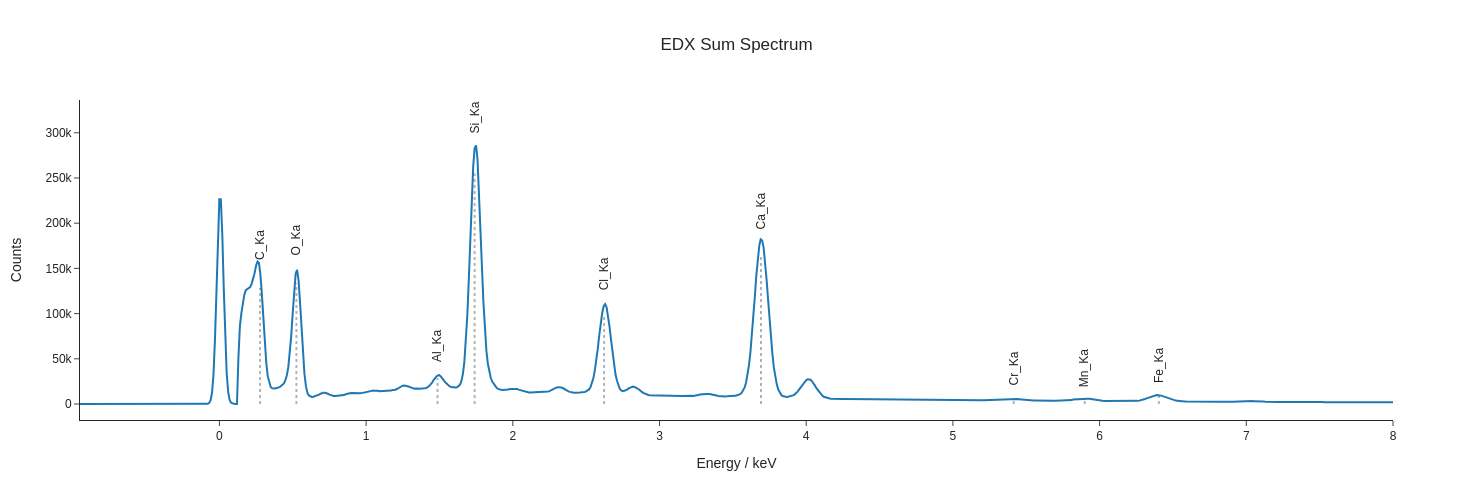

In [8]:
# Or check the sum spectrum using an interactive plot function (written by me).
plot_sum_spectrum(sem.edx)

In [4]:
search_energy_peak()

Output()

In [10]:
# Check the default elemental peaks
sem.feature_list

['Al_Ka', 'C_Ka', 'Ca_Ka', 'Cl_Ka', 'Cr_Ka', 'Fe_Ka', 'Mn_Ka', 'O_Ka', 'Si_Ka']

Set feature_list to ['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka']


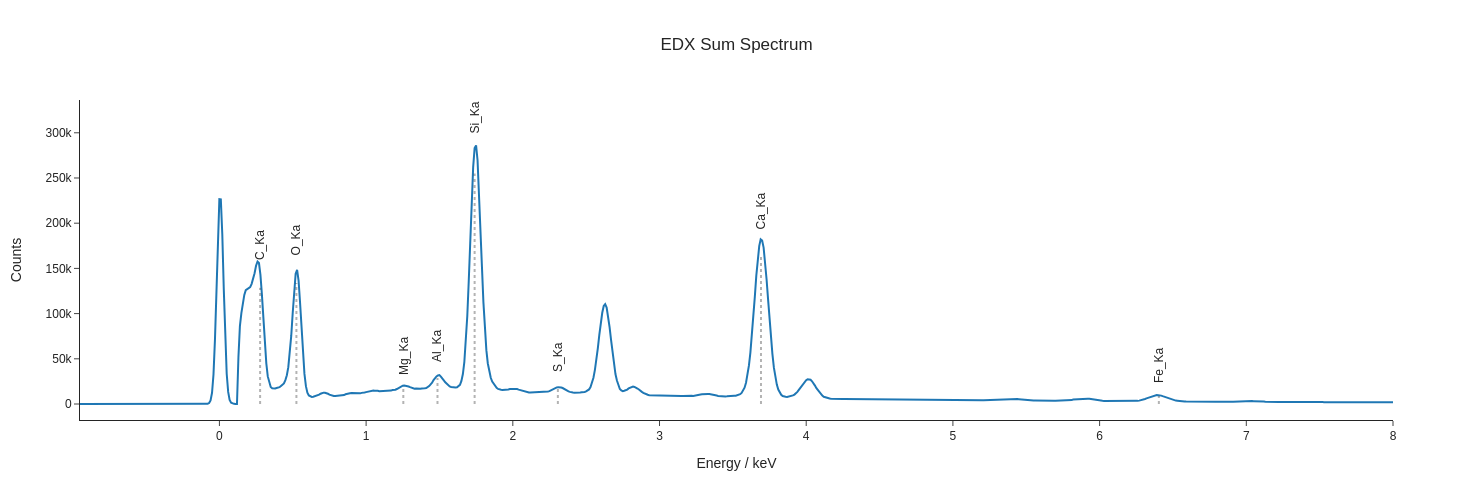

In [5]:
# Change the default elemental peaks
sem.set_feature_list(['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka'])
plot_sum_spectrum(sem.edx)

## Process the dataset
Some useful functions:
1. `sem.rebin_signal(size=(2,2))`: rebin the edx signal with the size of 2x2. After rebinning the dataset, we can access the binned edx or bse data using `sem.edx_bin` or `sem.bse_bin`.

2. `peak_intensity_normalisation(sem.edx_bin)`: normalise the x-ray intensity along energy axis.

3. `remove_fist_peak`: remove the first x-ray peak by calling the function with the argument `end`.

4. `peak_denoising_PCA`: denoise the spectrum using *Principle Component Analysis (PCA)*.

    > `n_components_to_reconstruct`: specify how many components to reconstruct the the EDX intensity profile.

    > `spectrum.plot_results`: True to plot all results.

5. `plot_intensity_maps`: Plot the elemental intensity maps.

In [6]:
# Rebin both edx and bse dataset
sem.rebin_signal(size=(2,2))

Rebinning the intensity with the size of (2, 2)


(<EDSSEMSpectrum, title: EDX, dimensions: (369, 336|1595)>,
 <Signal2D, title: Ch 0, dimensions: (|400, 400)>)

In [7]:
# Normalisation along energy axis
sem.peak_intensity_normalisation()

<EDSSEMSpectrum, title: EDX, dimensions: (369, 336|1595)>

Removing the fisrt peak by setting the intensity to zero until the energy of 0.1197 keV.


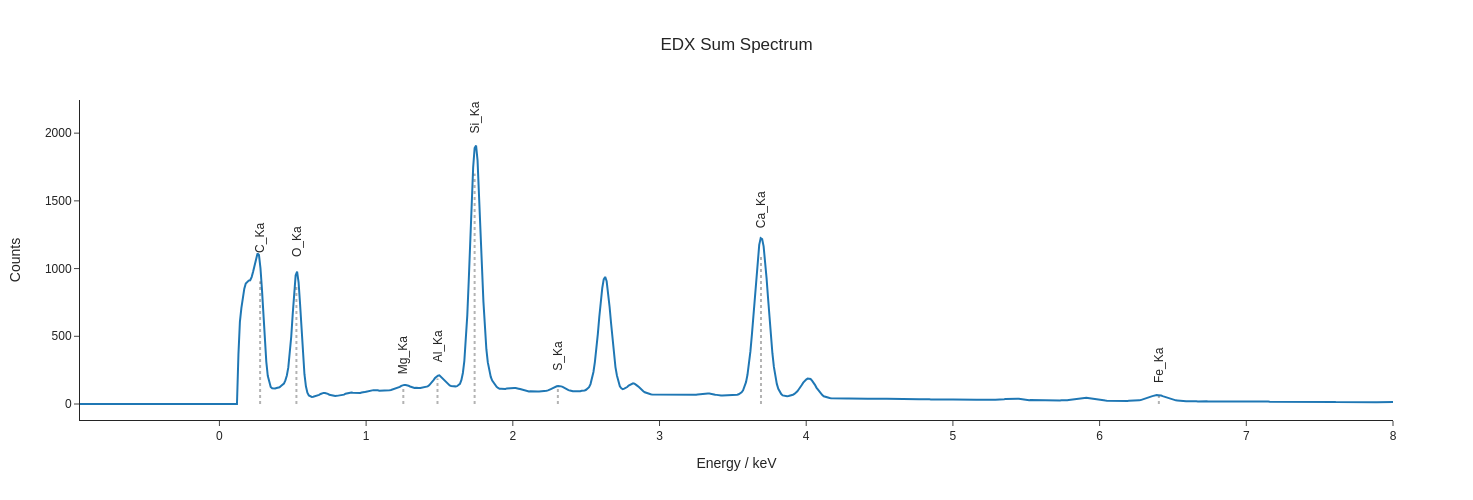

In [8]:
# Remove the first peak
end_energy = 0.1197 

sem.remove_fist_peak(end=end_energy) 
plot_sum_spectrum(sem.edx_bin)

In [9]:
# Denoise the X-ray profile using PCA.
sem.peak_denoising_PCA(n_components_to_reconstruct=10, plot_results=False)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=10
  centre=None


<EDSSEMSpectrum, title: EDX, dimensions: (369, 336|1595)>

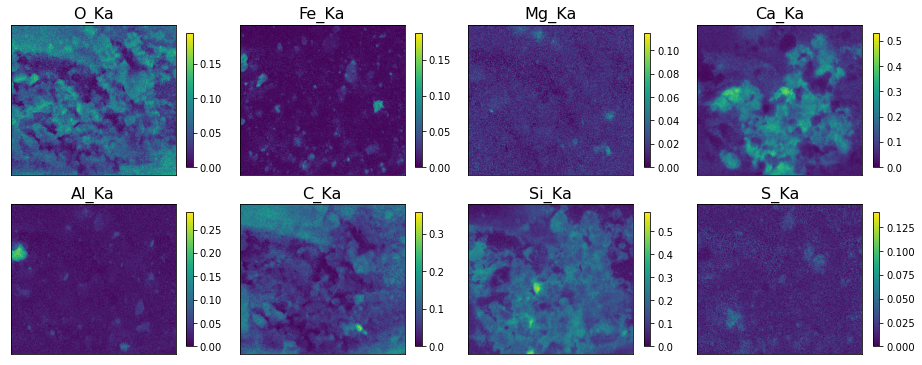

In [10]:
# Plot elemental intensity map
plot_intensity_maps(sem.edx_bin, sem.feature_list)

## Normalisation

Set feature_list to ['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka']


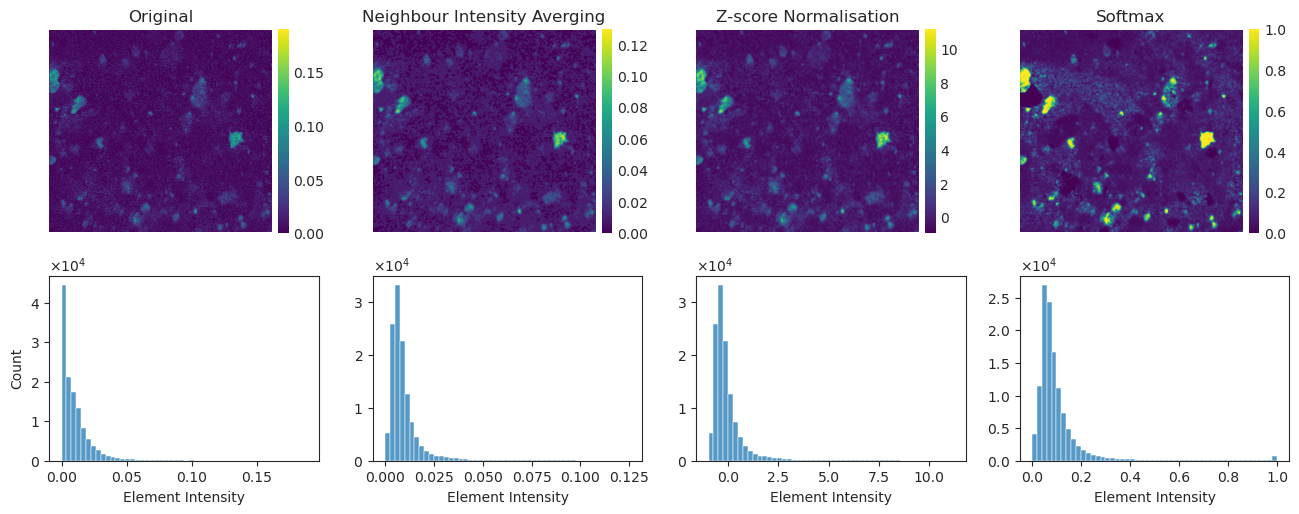

In [11]:
# Get a np.array from the object <sem>, size of dataset should be [336, 369, 8 (num_elements)]
feature_list = ['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka']
dataset = sem.get_feature_maps(feature_list)

# Process the dataset by averaging the neighboring intensity
dataset_processed = avgerage_neighboring_signal(dataset)

# Apply z-score normalisation on each intensity map
dataset_norm = z_score_normalisation(dataset_processed)

# Apply softmax along the axis=2 
dataset_softmax = softmax(dataset_norm)

# Plot intensity distributions after (1)avgerage_neighboring_signal; (2)z_score_normalisation; (3) softmax
plot_pixel_distributions(sem, peak='Fe_Ka')

# Autoencoder

## Initialise experiment / model

In [12]:
# Fix the random seed, so that we can reproduce the training if using the same seed.
same_seeds(1)

# Set up the experiment, e.g. determining the model structure, dataset for training etc.
general_results_dir='results' 
EX = Experiment(descriptor='AE_unmix',
                general_results_dir=general_results_dir,
                model=AutoEncoder,
                model_args={'hidden_layer_sizes':(512,256,128)}, # number of hidden layers and corresponding neurons
                chosen_dataset=dataset_softmax,
                save_model_every_epoch=True)

model_name: Model-AE_unmix
size_dataset: (336, 369, 8)
device: cuda
num_parameters: 341770


## Training

In [152]:
# Train the model (Can skip if you want to load the trained model parameters)
EX.run_model(num_epochs=50,
             patience=50, 
             batch_size=64,
             learning_rate=1e-4, 
             weight_decay=0.0, 
             task='train_eval', # Change to 'train_all' to train all the dataset without separate some parts for evaluation
             noise_added=0.0,
             lr_scheduler_args={'factor':0.5,
                                'patience':5, 
                                'threshold':1e-2, 
                                'min_lr':1e-7,
                                'verbose':True}) 

num_epochs: 50
batch_size: 64
task: train_eval
optimizer: lr=0.0001 and weight_decay=0.0

Start training ...



  0%|          | 0/1550 [00:00<?, ?batch/s]

Epoch 1 ----> model saved, test_loss = 0.001579


  0%|          | 0/1550 [00:00<?, ?batch/s]

Epoch 2 ----> model saved, test_loss = 0.001410


  0%|          | 0/1550 [00:00<?, ?batch/s]

Epoch 3 ----> model saved, test_loss = 0.001323


  0%|          | 0/1550 [00:00<?, ?batch/s]

Epoch 4 ----> model saved, test_loss = 0.001226


  0%|          | 0/1550 [00:00<?, ?batch/s]

Epoch 5 ----> model saved, test_loss = 0.001190


  0%|          | 0/1550 [00:00<?, ?batch/s]

  0%|          | 0/1550 [00:00<?, ?batch/s]

KeyboardInterrupt: 

## Loading model

In [13]:
# Load the trained model file 
EX.load_trained_model('results/Model-AE_unmix_best')

# Get the dimension-reduced dataset
latent = EX.get_latent()

Loading model parameters from results/Model-AE_unmix_best


# Gaussian mixture clustering

In [20]:
# Set up an object for GM clustering
PC = PhaseClassifier(latent, 
                     dataset_softmax, 
                     sem, 
                     method='BayesianGaussianMixture', 
                     method_args={'n_components':15, 'random_state':4, 'init_params':'kmeans'})

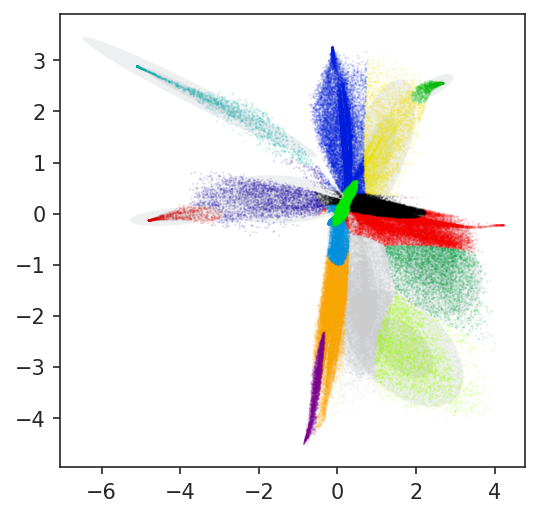

In [21]:
# Plot latent sapce (2-dimensional) with corresponding Gaussian models
PC.plot_latent_space()

In [22]:
PC.set_feature_list(['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka'])
show_cluster_distribution(PC)

Set feature_list to ['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka']


SelectMultiple(options=('All', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', '…

Output()

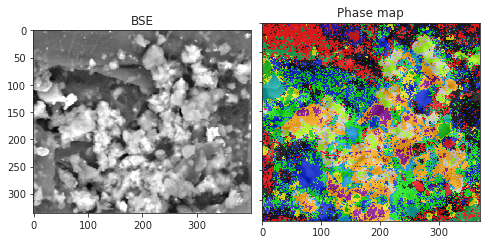

In [24]:
# Plot phase map using the corresponding GM model
PC.plot_phase_map()

In [25]:
# Given a cluster, plot the binary map and the x-ray profile 
# from the corresponding pixels in the binary map.
binary_filter_args={'threshold':0.8, 
                    'denoise':False, 
                    'keep_fraction':0.13, 
                    'binary_filter_threshold':0.5}

In [26]:
show_clusters(PC,binary_filter_args)

SelectMultiple(options=('cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster…

## Statistics of phase properties

In [27]:
show_cluster_stats(PC,binary_filter_args)

Output()

# Unmix x-ray profiles using Non-negative Matrix Fatorization (NMF)

In [29]:
weights, components = PC.get_unmixed_edx_profile(clusters_to_be_calculated='All',
                                                 n_components='All',
                                                 normalised=True, method='NMF', 
                                                 method_args={'init':'nndsvd'},
                                                 binary_filter_args=binary_filter_args)

In [30]:
show_unmixed_weights(weights)

SelectMultiple(options=('cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster…

In [31]:
PC.set_feature_list(['O_Ka','Fe_Ka','Mg_Ka','Ca_Ka','Al_Ka','C_Ka',
                  'Si_Ka','S_Ka','Cl_Ka','Cl_Kb','Ca_Kb','Mn_Ka',
                  'Cr_Ka','Fe_Kb', 'Fe_La', 'K_Ka'])

Set feature_list to ['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka', 'Cl_Ka', 'Cl_Kb', 'Ca_Kb', 'Mn_Ka', 'Cr_Ka', 'Fe_Kb', 'Fe_La', 'K_Ka']


In [32]:
show_unmixed_components(PC, components)

Dropdown(options=('cpnt_0', 'cpnt_1', 'cpnt_2', 'cpnt_3', 'cpnt_4', 'cpnt_5', 'cpnt_6', 'cpnt_7', 'cpnt_8', 'c…

In [75]:
search_energy_peak()

Output()